In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy.signal as spsig
import scipy.ndimage as spimg
import h5py as h5
# import Pulse as pulse
import glob
import itertools as itools
import functools as ftools

# logging and flow control
from logzero import logger
import multiprocessing

# jwave imports
from jwave.geometry import Domain, Medium, TimeAxis, Sources, sphere_mask, circ_mask
import jax.numpy as jnp
from jax import jit
from jwave import FourierSeries
from jwave.utils import show_field
import jax

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *

import Pulse as pulse

# pyvista/meshing imports
import pyvista as pv

In [2]:
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update( 'jax_enable_x64', False )
%matplotlib widget

# User edit
You should not have to change anyting beyond the next cell. 

In [3]:
############## user edit #######################

meshfile = './AcrylicWedge.stl'
maskfile = './BaselineHires3D.h5'
string_handle = 'Azimuthal'
padding_fraction = 0.1
num_points_along_largest_dimension = 800
pml_fraction = 0.5 # fraction of the buffer region outside the object used as PML

# multiprocess parameters
num_processes = 10

# material properties
materials = [ 'steel', 'acrylic', 'air', 'roll' ]
speeds = [ 5500., 2730., 341., 1041.865 ]
densities = [ 7850., 1180., 1.293, 1933.949 ] # jelly roll parameters for SOC = 0.3

# can/cell geometry
can_thickness = 0.16
can_center = 21.5
can_radius = 10.5
can_height = 70.
roll_inner_radius = 2.
cathode_location = -3.*np.pi/4. #+ ( TEMPLATE. / 21. ) * 115.*np.pi/180. 
cathode_thickness = 0.3 
cathode_wrapping_sense = 1.

# pulse characteristics
input_pulse_file = '/home/smaddali/simulations/input_signal.csv'
center_frequency = 2.e6 # Hz
pulse_hg_order = 3 # order of the Hermite-Gauss pulse
simulation_time = 30.e-6 # we simulate only 30 us for now, a little beyond what we currently measure.
c_mult = 0.05   # multiplier for max. Courant factor, to prevent diverging simulation. 

# azimuthal source details (this is a line source)
x_loc1 = [ -5., 5. ] # range of line source
y_loc1 = -11. 
# n_oscillators = 35

# axial source details (focus)
y_loc2, z_loc2 = -11., 10.
focal_length = 11.
num_elements = 32
element_separation = 0.3 # mm in Y

# display/visualization parameters
csf = 5. # color scale factor
frame_skip = 5

################################################

# Stop!
Don't edit anything beyond this cell, unless you know what you're doing. 

# Acoustic impedance and reflectivity

In [4]:
list( itools.combinations( materials, 2 )  )

[('steel', 'acrylic'),
 ('steel', 'air'),
 ('steel', 'roll'),
 ('acrylic', 'air'),
 ('acrylic', 'roll'),
 ('air', 'roll')]

In [5]:
material_properties = { key: [ val1, val2 ] for key, val1, val2 in zip( materials, speeds, densities ) }
reflectivity = { 
    key: ( np.prod( material_properties[ key[0] ] ) - np.prod( material_properties[ key[1] ] ) ) / ( np.prod( material_properties[ key[0] ] ) + np.prod( material_properties[ key[1] ] ) )
    for key in list( itools.combinations( materials, 2 ) )
}

In [6]:
material_properties

{'steel': [5500.0, 7850.0],
 'acrylic': [2730.0, 1180.0],
 'air': [341.0, 1.293],
 'roll': [1041.865, 1933.949]}

In [7]:
reflectivity

{('steel', 'acrylic'): 0.8611357777758619,
 ('steel', 'air'): 0.9999795757499783,
 ('steel', 'roll'): 0.9108246240556087,
 ('acrylic', 'air'): 0.9997262974728385,
 ('acrylic', 'roll'): 0.23040754946765896,
 ('air', 'roll'): -0.9995624462506273}

# Grid details
Using the mesh for the acrylic wedge and manually adding the can to it, in order to generate the mask for the wedge-can system. 
This works better than using the wedge-can mesh because of ambiguous definitions of "inside" and "outside" of the mesh. 

In [8]:
# dimensions and grid size calculations
mesh = pv.read( meshfile )
bounds = np.array( mesh.bounds ).reshape( -1, 2 )

# the can is added in the y-direction. 
bounds[1,1] += 21. # add diameter of can
bounds[2,:] = [ -35., 35. ]
largest_dimension = np.diff( bounds, axis=1 ).max()
excess_padding = largest_dimension * padding_fraction / 2. 
dx_mm = ( largest_dimension + 2*excess_padding ) / num_points_along_largest_dimension # spatial step size
pml_size = np.round( excess_padding * pml_fraction / dx_mm ).astype( int )
grid_ranges = [ 
    np.arange( mn, mx, dx_mm )
    for mn, mx in list( 
        bounds + np.array( [ -excess_padding, excess_padding ] )[np.newaxis,:].repeat( 3, axis=0 )
    )
]
for n in range( len( grid_ranges ) ):
    if grid_ranges[n].size%2 != 0: 
        # grid_ranges[n] = np.concatenate( ( grid_ranges[n], np.array( [ grid_ranges[n][-1] + dx_mm ] ) ) )
        grid_ranges[n] = np.linspace( grid_ranges[n].min(), grid_ranges[n].max(), grid_ranges[n].size+1 )

dx_final = [ ( ar[1:]-ar[:-1] ).mean() for ar in grid_ranges ]

shp = tuple( ar.shape[0] for ar in grid_ranges )
shp = ( shp[1], shp[0], shp[2] )
logger.info( f'Domain size: {shp} pixels. ' )
logger.info( f'PML buffer size: {pml_size} pixels. ')
logger.info( f'Step size: {dx_final} mm. ')


2025-05-19 13:03:51 - jwave [INFO]: Domain size: (546, 302, 800) pixels. 
2025-05-19 13:03:51 - jwave [INFO]: PML buffer size: 18 pixels. 
2025-05-19 13:03:51 - jwave [INFO]: Step size: [0.0962499999999995, 0.09607339449541234, 0.09624999999999773] mm. 


In [9]:
# # create function that determines if points are inside can
def inside_can( pts, center, radius, thickness, height ):
    rho = np.sqrt( pts[:,0]**2 + ( pts[:,1]-center )**2 )
    return ftools.reduce( np.logical_and, [ rho >= radius - thickness, rho <= radius, np.abs( pts[:,-1] ) < height/2. ] )

def jelly_roll_volume( pts, center, radius, radius_inner, thickness, height ):
    rho = np.sqrt( pts[:,0]**2 + ( pts[:,1]-center )**2 )
    return ftools.reduce( np.logical_and, [ rho < radius - thickness, rho >= radius_inner, np.abs( pts[:,-1] ) < height/2. ] ), rho
        
def jelly_roll_with_cathode_edge( 
    pts, center, radius, 
    radius_inner, can_thickness, can_height, 
    theta0=0., cathode_thickness=0.1, sense=1, 
    crack_edge_dist=None, 
    crack_depth=None, 
    crack_width=None
):
    rho = np.sqrt( pts[:,0]**2 + ( pts[:,1]-center )**2 )
    R = np.array( [ [ np.cos( theta0 ), np.sin( theta0 ) ], [ np.cos( np.pi/2. + theta0 ), np.sin( np.pi/2. + theta0 ) ] ] )
    pts_relative = pts[:,:2] # get 2D points
    pts_relative[:,-1] = pts_relative[:,-1] - center
    pts_relative = pts_relative.T # make this a 2xN array
    pts_proj = R @ pts_relative
    theta = np.arctan2( pts_proj[1], pts_proj[0] ) # canonical range from -pi to pi
    # dtheta = np.arccos( ( radius - can_thickness - cathode_thickness ) / ( radius - can_thickness ) )
    # print( f'dtheta = {dtheta*180/np.pi}' )
    inside_roll = ftools.reduce( 
        np.logical_and, 
        [
            rho < radius - can_thickness, 
            np.abs( pts[:,-1] ) < can_height/2., 
            rho >= radius_inner
        ]
    )
    cathode_segment = ftools.reduce( 
        np.logical_and, 
        [ 
            inside_roll,
            pts_proj[0] < can_radius - can_thickness - cathode_thickness, 
            # np.abs( theta ) > dtheta
        ]
    )
    final = ftools.reduce( 
        np.logical_or, 
        [ 
            cathode_segment, 
            np.logical_and( np.sign( theta )==np.sign( sense ), inside_roll )
        ]
    )
    if crack_depth is None and crack_edge_dist is None and crack_width is None: # no crack in jelly roll
        return final
    assert all( [ isinstance( var, float ) for var in [ crack_depth, crack_width, crack_edge_dist ] ] ), 'Crack parameters should be floats. '
    theta_d = theta0 + crack_edge_dist # the latter in radians
    R = np.array( [ [ np.cos( theta_d ), np.sin( theta_d ) ], [ np.cos( np.pi/2. + theta_d ), np.sin( np.pi/2. + theta_d ) ] ] )
    pts_proj = R @ pts_relative
    theta = np.arctan2( pts_proj[1], pts_proj[0] ) # canonical range from -pi to pi
    crack_volume = ftools.reduce( 
        np.logical_and, 
        [ 
            np.abs( theta ) < crack_width/2., 
            rho >= radius - can_thickness - crack_depth, 
            rho <  radius - can_thickness
        ]
    )
    final = np.logical_and( final, np.logical_not( crack_volume ) ) # carve out a void where the crack is
    return final

# Animuthal and axial slices

In [10]:
xygrid = np.meshgrid( *( grid_ranges[:2] ) )
pts_azim = np.concatenate( tuple( ar.ravel()[:,np.newaxis] for ar in xygrid ), axis=1 )
pts_azim = np.concatenate( ( pts_azim, np.zeros( ( pts_azim.shape[0], 1 ) ) ), axis=1 )

yzgrid = np.meshgrid( *(grid_ranges[1:] ) )
pts_axial = np.concatenate( tuple( ar.ravel()[:,np.newaxis] for ar in yzgrid ), axis=1 )
pts_axial = np.concatenate( ( np.zeros( ( pts_axial.shape[0], 1 ) ), pts_axial ), axis=1 )

In [11]:
def get_domain_image( pts, mesh, shape, inside_can_function ):
    can_region = inside_can_function( pts ).reshape( shape )
    wedge_region = pv.PolyData( pts ).select_enclosed_points( mesh, progress_bar=True )
    wedge_region = wedge_region['SelectedPoints'].reshape( shape )
    wedge_region = spimg.binary_erosion( spimg.binary_dilation( wedge_region.astype( bool ) ) ).astype( np.uint8 )
    im = wedge_region + 2*can_region
    im[ np.where( im==3 ) ] = 2
    return im


inside_can_function = ftools.partial( inside_can, center=can_center, radius=can_radius, thickness=can_thickness, height=can_height )
im_azim = get_domain_image( pts_azim, mesh, ( grid_ranges[1].size, grid_ranges[0].size ), inside_can_function )
im_axial = get_domain_image( pts_axial, mesh, ( grid_ranges[2].size, grid_ranges[1].size ), inside_can_function )

Selecting Enclosed Points: 100%|██████████[00:00<00:00]
Selecting Enclosed Points: 100%|██████████[00:01<00:00]


In [12]:
# jr_azim = jelly_roll_volume( pts_azim, can_center, can_radius, roll_inner_radius, can_thickness, can_height )[0].reshape( grid_ranges[1].size, grid_ranges[0].size )
jr_azim = jelly_roll_with_cathode_edge( 
    pts_azim,
    can_center, 
    can_radius, 
    roll_inner_radius, 
    can_thickness, 
    can_height, 
    theta0=cathode_location, 
    cathode_thickness=cathode_thickness, 
    sense=cathode_wrapping_sense, 
    crack_edge_dist=-25.*np.pi/180., 
    crack_depth=0.5, 
    crack_width=3.*np.pi/180.
).reshape( grid_ranges[1].size, grid_ranges[0].size )
assert im_azim.max()==2., 'Rogue pixels in im_azim. '
im_azim = im_azim + 3.*jr_azim
im_azim[ np.where( np.abs( im_azim-4. ) < 0.5 ) ] = 3.

jr_axial = jelly_roll_with_cathode_edge( 
    pts_axial, 
    can_center, 
    can_radius, 
    roll_inner_radius, 
    can_thickness, 
    can_height, 
    theta0=cathode_location, 
    cathode_thickness=cathode_thickness, 
    sense=cathode_wrapping_sense
).reshape( grid_ranges[2].size, grid_ranges[1].size )
assert im_axial.max()==2., 'Rogue pixels in im_axial. '
im_axial = im_axial + 3.*jr_axial
im_axial[ np.where( np.abs( im_axial-4. ) < 0.5 ) ] = 3.

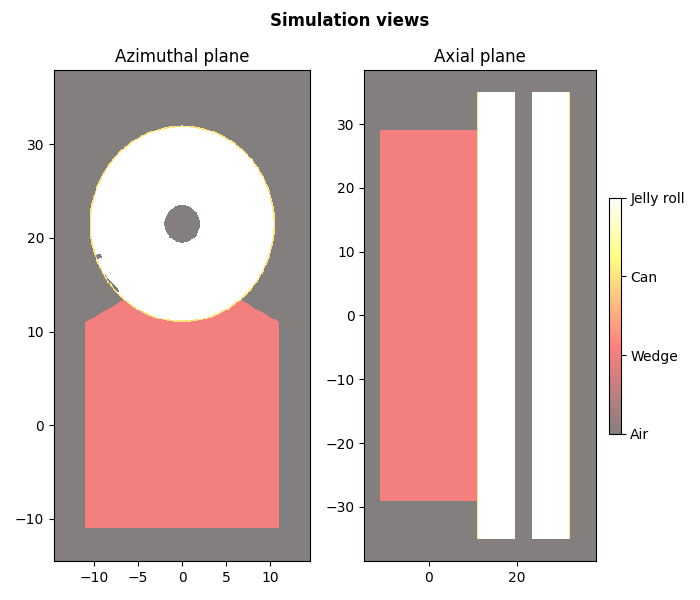

In [13]:
fig = plt.figure( figsize=( 7, 6 ) )
ax = fig.subplots( 1, 2 )
my_cmap = 'hot'

ax[0].pcolormesh( grid_ranges[0], grid_ranges[1], im_azim, cmap=my_cmap, alpha=0.5 )
# ax[0].contour( grid_ranges[0], grid_ranges[1], spimg.gaussian_filter( im_azim, sigma=1. ), levels=[ 0.15 ], colors='k' )

im1 = ax[1].pcolormesh( grid_ranges[1], grid_ranges[2], im_axial, cmap=my_cmap, alpha=0.5 )
cbar = fig.colorbar( im1, ax=ax[1], fraction=0.046, pad=0.05 )
cbar.set_ticks( [ 0., 1., 2., 3. ] )
cbar.set_ticklabels( [ 'Air', 'Wedge', 'Can', 'Jelly roll' ] )
# ax[1].contour( grid_ranges[1], grid_ranges[2], spimg.gaussian_filter( im_axial, sigma=1. ), levels=[ 0.15 ], colors='k' )


for myax, titl in zip( ax, ['Azimuthal', 'Axial'] ):
    myax.axis( 'tight' )
    myax.set_title( f'{titl} plane' )

plt.suptitle( 'Simulation views', weight='bold' )
plt.tight_layout()


# `jwave` definitions

## Cross section simulations

### Azimuthal

In [ ]:
medium_dict = { 0:'air', 1:'acrylic', 2:'steel', 3:'roll' }
def get_medium_properties( im, medium_dict ):
    def get_region( in_data ):
        return ( in_data[0]==in_data[1] )*in_data[2]
    sound_speed_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][0] ] )
            for idx in np.unique( im )
        ]
    )
    density_map = ftools.reduce( 
        lambda x, y: x + y, 
        [ 
            get_region( [ im, idx, material_properties[ medium_dict[ idx ] ][1] ] )
            for idx in np.unique( im )
        ]
    )
    return sound_speed_map, density_map

speed_map, density_map = get_medium_properties( im_azim, medium_dict )
dx = ( float( dx_final[1] )*1.e-3, float( dx_final[0] )*1.e-3 )
domain_azim = Domain( ( shp[0], shp[1] ), dx )
speed_field = FourierSeries( jnp.expand_dims( speed_map, axis=-1 ), domain=domain_azim )
density_field = FourierSeries( jnp.expand_dims( density_map, axis=-1 ), domain=domain_azim )

medium = Medium(domain=domain_azim, sound_speed=speed_field, density=density_field, pml_size=int( pml_size ), attenuation=0.95 )

In [ ]:
# show_field( speed_map )
# show_field( density_map )

In [ ]:
# with h5.File( 'Sections.h5', 'a' ) as fid: 
#     fid.create_group( 'azim' )
#     fid[ 'azim' ].create_dataset( 'speed_map', data=speed_map )
#     fid[ 'azim' ].create_dataset( 'density_map', data=density_map )
#     for key, val in { 
#         'x':grid_ranges[0], 
#         'y':grid_ranges[1], 
#         'z':grid_ranges[2]
#     }.items():
#         fid[ 'azim' ].attrs[ key ] = val

## Time domain

In [ ]:
# calculating time-domain characteristics of pulse
center_wavelength = material_properties[ 'acrylic' ][0] / center_frequency # pulse wavelength
period = 1. / center_frequency 
dx_dv_largest = dx_mm*1.e-3/ min( [ prop[0] for _, prop in material_properties.items() ] )
cfl_max = 0.5 * period / dx_dv_largest # courant number
cfl = cfl_max * c_mult

# time axis object
time_axis = TimeAxis.from_medium( medium, cfl=cfl )
time_axis.t_end = simulation_time # this is all we are currently measuring

# pulse details
# input_pulse = pd.read_csv( input_pulse_file )


logger.info( f'Dominant frequency: {center_frequency:2e} Hz' )
logger.info( f'Dominant_wavelength: {center_wavelength:.2e} m' )
logger.info( f'Sample points per dominant wavelength: {int(center_wavelength/(dx_mm*1.e-3))}' )
logger.info( f'Dominant time period: {period:.2e} sec' )
logger.info( f'Courant factor: {cfl:.2e}' )
logger.info( f'Time step: {time_axis.dt:.2e} sec' )

t = np.arange( 0., float( time_axis.t_end ), float( time_axis.dt ) )
init = pulse.HermiteGauss( t, 1.5*period, period/2., pulse_hg_order )
plt.figure()
plt.plot( t, init, label=f'Single-element pulse (HG{pulse_hg_order})' )
plt.xlabel( 'Simulation time (sec) $\\longrightarrow$' ) 
plt.legend()
plt.grid()

# create phased array for focused probe
# array_extent = element_separation * ( num_elements - 1 )
# element_locations = z_loc2 + np.linspace( -array_extent/2., array_extent/2., num_elements )
# delta_f = focal_length - np.sqrt( focal_length**2 - ( element_locations - z_loc2 )**2 )
# delay = -delta_f * 1.e-3 / material_properties[ 'acrylic' ][0] # time delay in seconds
# delay -= delay.min() # generates a focused wavefront 
# delay_steps = np.round( delay / time_axis.dt ).astype( int )

# sources = [ 
#     np.roll( init, dstep )
#     for dstep in delay_steps
# ]
# positions = [ 
#     element_locations, 
#     y_loc2]

# plt.figure()
# for n, src in enumerate( sources ):
#     plt.plot( t, n+src )

# sources = Sources( 
#     positions=( ( y_loc,  ),  ( x_loc, ) ), 
#     signals=jnp.stack( [ init] ),
#     dt=time_axis.dt, 
#     domain=domain_azim
# )

# Run simulation

## Azimuthal

In [ ]:
# xloc_w = np.linspace( x_loc1[0], x_loc1[1], n_oscillators )
# xloc = np.unique( np.round( grid_ranges[0].size * ( xloc_w - grid_ranges[0].min() ) / ( grid_ranges[0].max() - grid_ranges[0].min() ) ).astype( int ) )

xloc = np.round( grid_ranges[0].size * ( x_loc1 - grid_ranges[0].min() ) / ( grid_ranges[0].max() - grid_ranges[0].min() ) ).astype( int )
xloc = np.arange( xloc[0], 1+xloc[1] )
yloc = 1 + np.array( [ np.argmin( np.abs( grid_ranges[1] - y_loc1 ) ) ]*xloc.size )

# print( xloc, yloc )

sources = Sources( 
    positions=( yloc, xloc ), 
    signals=jnp.stack( [ init ]*yloc.size ),
    dt=time_axis.dt, 
    domain=domain_azim
)

In [ ]:
@jit
def compiled_simulator( sources ):
    return simulate_wave_propagation( medium, time_axis, sources=sources )

In [ ]:
pressure = compiled_simulator( sources )
pres = np.squeeze( pressure.on_grid )
logger.info( f'Simulation size: {pres.shape}' )
pmax = min( np.abs( pres.min() ), np.abs( pres.max() ) )
pmin = -pmax

In [ ]:
print( pmin, pmax )

In [ ]:
with h5.File( f'JR_cathode_edge_bigcrack_30us_linesource_thetascan_TEMPLATE.h5', 'w' ) as fid: 
    fid.create_dataset( 'image', data=im_azim )
    fid.create_dataset( 'pressure', data=pres[::frame_skip,:,:] )
    for key, val in {
        'x':grid_ranges[0], 
        'y':grid_ranges[1], 
        'xloc':xloc, 
        'yloc':yloc, 
        'my_cmap':my_cmap, 
        'pmin':pmin, 
        'pmax':pmax,
        'csf':csf, 
        't':t[::frame_skip], 
        'time_steps':t[::frame_skip].size, 
        'dt':time_axis.dt*frame_skip
    }.items():
        fid[ 'pressure' ].attrs[ key ] = val 


# Visualization

In [ ]:
# fig = plt.figure( figsize=( 14, 5 ) )
# ax = fig.subplots( 1, 2 )
# # ax[0].contour( im_azim, levels=[ 0.5 ], colors='black' )
# ax[0].pcolormesh( np.arange( grid_ranges[0].size ), np.arange( grid_ranges[1].size ), im_azim, cmap=my_cmap, alpha=0.25 )
# fld = ax[0].imshow( pres[-100,:,:], origin='lower', cmap='seismic' )
# ax[0].plot( xloc, yloc, '^k', markersize=3, label='Source' )
# fld.set_clim( [ pmin/csf, pmax/csf ] )
# ax[0].axis( 'equal' )
# ax[0].axis( 'square' )
# titl = ax[0].set_title( 'Pressure wave at time step 0' )
# ax[0].legend()

# ax[1].plot( t/1.e-6, pres[:,yloc+4, xloc] )
# ax[1].axis( 'tight' )
# ax[1].grid()
# ax[1].set_title( '2D pulse echo signal' )
# plt.suptitle( f'{string_handle} wave profile ({center_frequency/1.e6} MHz pulse)', weight='bold' )


# plt.tight_layout()

# # def animate( n ):
# #     fld.set_data( pres[n,:,:] )
# #     fld.set_clim( [ pmin/csf, pmax/csf ] )
# #     titl.set_text( f'Pressure wave at time {(n*time_axis.dt/1.e-6):.2e} us' )
# #     return fld,

# # ani = animation.FuncAnimation( fig, animate, interval=10, frames=pres.shape[0], blit=False, repeat=False )
# # plt.show()